# Living Income Analysis: Machine Learning Model with max 10 features

## Summary:

In this notebook I develop a Restricted Machine Learning model that can predict whether a cocoa farming household in Ghana and Côte d'Ivoire reach a Living Income. The Machine Learning model is restricted to 10 features, to make its real-world application easy and cost-effective.

I use as starting point the Machine Learning model prepared at [Living Income Analysis: Machine Learning notebook](LivingIncome_MachineLearning.ipynb), which in turn used
as starting point the dataset prepared at [Living Income Analysis notebook](LivingIncomeAnalysis.ipynb)

In this notebook, specifically I will:

* Load the dataset
* Extract the top 10 features
* Re-fit the best classifier with the restricted dataset, using Grid Search with a stratified sross-validation
* Search broadly using TPOT, with the same stratified cross-validation set 
* Compare performance and choose the best classifier with the restricted data
* Calibrate the probabilities
* Export the final model such that it can be used in a web-app and by others

# 0 Preamble

## 0.1 Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from time import time

from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from tpot import TPOTClassifier

from sklearn.calibration import CalibratedClassifierCV

import visuals as vs # this is a slightly modifed code which provided via de Udacity Nanodegree Intro to Machine Learning

C:\Users\marcelot\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


## 0.1 Load Data

Load data as in the previous notebook [Living Income Analysis: Machine Learning notebook](LivingIncome_MachineLearning.ipynb)

In [2]:
data = pd.read_pickle('../data/data_ready_for_ML.pkl')

Apply the same strategy to fill missing values, so the data is identical:

* For categorical variables, use the mode
* For numerical variable, use the median

The strategy above is also quite robust to outliers, as the mode and median are typically quite stable and not sensitive to extreme values

In [3]:
# iterate through all features
for this_column in list(data.columns):

    # check if categorical
    if (str(data[this_column].dtype) == 'category') | (str(data[this_column].dtype) == 'object') :
        fill_value = data[this_column].mode()

    else:
        fill_value = data[this_column].median()
     
    # fill missing values
    data[this_column] = data[this_column].fillna(value = fill_value)

Split into features and target

In [4]:
target = data['Living Income Achieved']
data.drop(['Living Income Achieved'], axis = 1, inplace = True)

Expand dummies, to maintain the original shape

In [5]:
data = pd.get_dummies(data)

Check shape, which should be `(1377, 838)`

In [6]:
data.shape

(1377, 838)

## 0.2 Load Best ML Model

Load the best model from the previous notebook [Living Income Analysis: Machine Learning notebook](LivingIncome_MachineLearning.ipynb)

In [7]:
best_model = pd.read_pickle('../models/best_overall.pkl')

Get the 10 best features:

In [8]:
top_10_features = pd.DataFrame({'Feature weight': best_model.feature_importances_}, index=data.columns).sort_values(by='Feature weight', ascending=False).head(n=10)
top_10_features

,Feature weight
Estimated income percentage from sale of cocoa,0.092667
Cocoa production (kg/ha),0.090667
Cocoa production (kg),0.059333
Productive land under cocoa (ha),0.042000
Cocoa land owned (ha),0.029333
Hectares with trees between 5 and 25 years old,0.022000
Estimated income percentage from own small business or trading,0.021333
Head: age,0.020667
Estimated income percentage from sale of other crops,0.020000
Land used to cultivate all crops (ha),0.014667


Plot the top 10 features

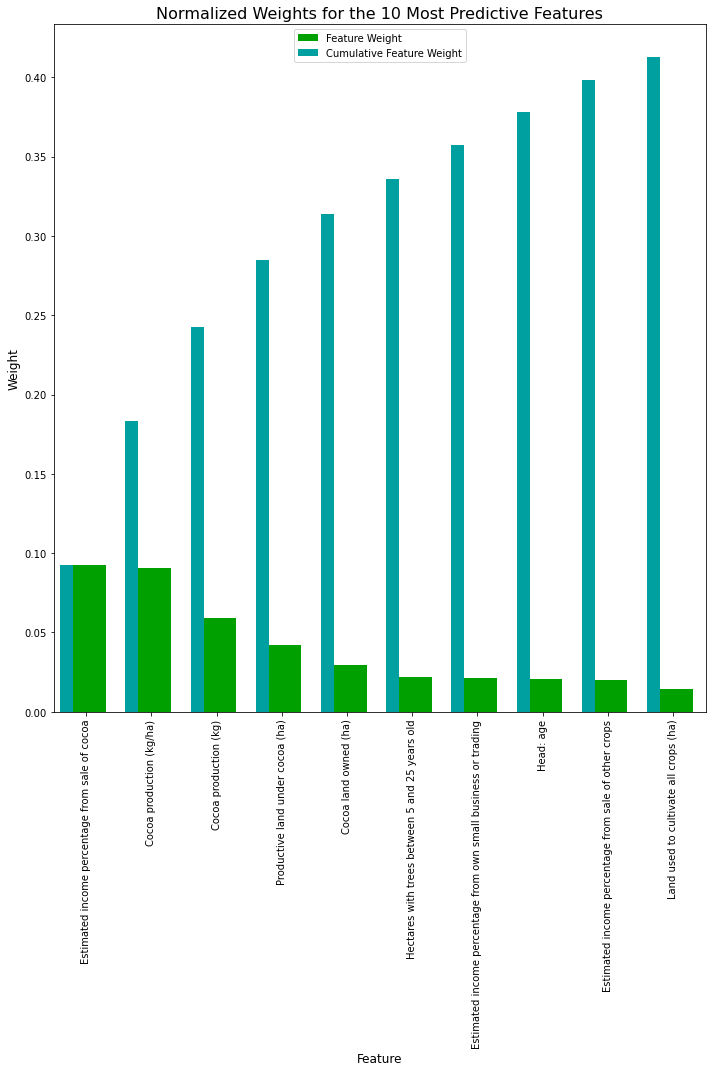

In [9]:
vs.feature_plot(best_model.feature_importances_, data, target, n_features= 10)

Store previous performance metrics for comparison

In [10]:
FULL_adaOptimStrat_accuracy = 0.9652
FULL_adaOptimStrat_fscore = 0.8667

In [11]:
print("ADAboost, Full Data Optimized Stratified Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(FULL_adaOptimStrat_accuracy, FULL_adaOptimStrat_fscore))

ADAboost, Full Data Optimized Stratified Predictor: [Accuracy score: 0.9652, F-score: 0.8667]


# 1. Get Data ready

Extract top 10 features:

In [12]:
data_top10 = data[top_10_features.index]

Confirm shape:

In [13]:
data_top10.shape

(1377, 10)

Check basic descriptives

In [14]:
data_top10.describe()

,Estimated income percentage from sale of cocoa,Cocoa production (kg/ha),Cocoa production (kg),Productive land under cocoa (ha),Cocoa land owned (ha),Hectares with trees between 5 and 25 years old,Estimated income percentage from own small business or trading,Head: age,Estimated income percentage from sale of other crops,Land used to cultivate all crops (ha)
count,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000
mean,0.636099,401.369812,1103.353516,3.062010,3.088592,2.452408,0.077807,50.591140,0.205309,5.279385
std,0.208974,239.152969,947.675598,2.325436,2.597953,2.076498,0.132000,13.217897,0.170920,3.430948
min,0.050000,20.000000,20.000000,0.202343,0.000000,0.000000,0.000000,16.000000,0.000000,0.352800
25%,0.500000,221.036102,447.999969,1.500000,1.500000,1.011716,0.000000,41.000000,0.100000,2.832804
50%,0.650000,355.831177,768.000000,2.428118,2.450000,2.000000,0.000000,50.000000,0.200000,4.249603
75%,0.800000,525.000000,1478.000000,4.000000,4.046863,3.237490,0.100000,60.000000,0.300000,6.717792
max,1.000000,1423.324829,5600.000000,15.000000,15.000000,13.750000,0.900000,95.000000,0.900000,21.000000


Export the data used for the restricted model:

In [15]:
data_for_restricted_ML = pd.concat([target, data_top10], axis = 1)

In [16]:
data_for_restricted_ML.head()

,Living Income Achieved,Estimated income percentage from sale of cocoa,Cocoa production (kg/ha),Cocoa production (kg),Productive land under cocoa (ha),Cocoa land owned (ha),Hectares with trees between 5 and 25 years old,Estimated income percentage from own small business or trading,Head: age,Estimated income percentage from sale of other crops,Land used to cultivate all crops (ha)
0,False,0.89,177.915604,576.0,3.237490,4.046863,3.237490,0.00,49.0,0.11,4.856235
1,False,0.60,722.958618,1024.0,1.416402,1.618745,1.416402,0.00,63.0,0.25,3.035147
2,False,0.50,210.862946,128.0,0.607029,0.607029,0.607029,0.35,53.0,0.15,0.809373
3,False,0.65,316.294403,512.0,1.618745,1.618745,1.618745,0.00,65.0,0.30,2.428118
5,False,0.80,197.683990,320.0,1.618745,2.428118,1.618745,0.00,60.0,0.00,2.428118


In [17]:
data_for_restricted_ML.to_pickle('../data/data_for_restricted_ML.pkl')

# 2. Grid Search best parameters, using stratified shuffle split

Split data in training and test set:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_top10, target,
                                                    train_size=0.75, test_size=0.25,
                                                   random_state = 32)

## 2.1 Re-fit AdaBoostClassifier

Prepare elements for the grid search. using the same parameters as in the previous notebook

In [19]:
# base classifier
clf = AdaBoostClassifier(random_state=42)

# Create the parameters list to tune
parameters = {'n_estimators':[10, 50, 500, 1200, 1500, 2000],
              'learning_rate':[1.0,1.5,2.0]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta= 0.5)

# Make sure it is stratified
cv_strat = StratifiedShuffleSplit(n_splits=5,
                                  test_size=0.2,
                                  random_state=42)


Run the grid search

In [20]:
## Create a Grid Search instance, using stratified CV
grid_obj_strat = GridSearchCV(clf, parameters, scoring = scorer, verbose=2,
                             cv = cv_strat, n_jobs = -1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_strat = grid_obj_strat.fit(X_train, y_train)

# Get the estimator
best_clf_strat = grid_fit_strat.best_estimator_

# print best model:
print("Best model:")
print(best_clf_strat)
print("------")

# Make predictions 
best_predictions_strat = best_clf_strat.predict(X_test)

# metrics
adaOptimStrat_accuracy = accuracy_score(y_test, best_predictions_strat)
adaOptimStrat_fscore = fbeta_score(y_test, best_predictions_strat, beta = 0.5)

print("\nRestricted Optimized Model with stratification\n------")
print("Final accuracy score on the testing data: {:.4f}".format(adaOptimStrat_accuracy))
print("Final F-score on the testing data: {:.4f}".format(adaOptimStrat_fscore))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   52.2s finished


Best model:
AdaBoostClassifier(n_estimators=500, random_state=42)
------

Restricted Optimized Model with stratification
------
Final accuracy score on the testing data: 0.9536
Final F-score on the testing data: 0.8458


Because the solution is on the limits (`learning rate = 1.0`), let's expand grid parameters:

In [21]:
parameters = {'n_estimators':[10, 50, 500, 1200, 1300, 1500, 1600, 2000],
              'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.5,1.0,1.5,2.0]}

Re-run Grid Search

In [22]:
## Create a Grid Search instance, using stratified CV
grid_obj_strat = GridSearchCV(clf, parameters, scoring = scorer, verbose=2,
                             cv = cv_strat, n_jobs = -1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_strat = grid_obj_strat.fit(X_train, y_train)

# Get the estimator
best_clf_strat = grid_fit_strat.best_estimator_

# print best model:
print("Best model:")
print(best_clf_strat)
print("------")

# Make predictions 
best_predictions_strat = best_clf_strat.predict(X_test)

# metrics
adaOptimStrat_accuracy = accuracy_score(y_test, best_predictions_strat)
adaOptimStrat_fscore = fbeta_score(y_test, best_predictions_strat, beta = 0.5)

print("\nRestricted Optimized Model with stratification\n------")
print("Final accuracy score on the testing data: {:.4f}".format(adaOptimStrat_accuracy))
print("Final F-score on the testing data: {:.4f}".format(adaOptimStrat_fscore))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.9min finished


Best model:
AdaBoostClassifier(learning_rate=0.1, n_estimators=1500, random_state=42)
------

Restricted Optimized Model with stratification
------
Final accuracy score on the testing data: 0.9623
Final F-score on the testing data: 0.8780


Compare full with the restricted model

In [23]:
print("ADAboost, Full Data Optimized Stratified Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(FULL_adaOptimStrat_accuracy, FULL_adaOptimStrat_fscore))
print("ADAboost, Restricted Data Optimized Stratified Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaOptimStrat_accuracy, adaOptimStrat_fscore))

ADAboost, Full Data Optimized Stratified Predictor: [Accuracy score: 0.9652, F-score: 0.8667]
ADAboost, Restricted Data Optimized Stratified Predictor: [Accuracy score: 0.9623, F-score: 0.8780]


Check broader performance metrics

In [24]:
precision_recall_fscore_support(y_test, best_predictions_strat, beta = 0.5)

(array([0.9704918, 0.9      ]),
 array([0.98666667, 0.8       ]),
 array([0.97368421, 0.87804878]),
 array([300,  45], dtype=int64))

In [25]:
confusion_matrix(y_test, best_predictions_strat)

array([[296,   4],
       [  9,  36]], dtype=int64)

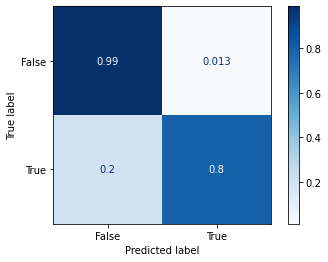

In [26]:
plot_confusion_matrix(best_clf_strat, 
                      X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize = 'true');

Let's save the best model so far:

In [27]:
pkl_filename = '../models/restricted_ada_best_strat.pkl'
pickle.dump(best_clf_strat, open(pkl_filename, 'wb'))

## 2.1 Search broadly using TPOT

In [28]:
pipeline_optimizer = TPOTClassifier()

In [29]:
pipeline_optimizer = TPOTClassifier(verbosity=2,
                                     n_jobs = -1,
                                    random_state = 32,
                                   periodic_checkpoint_folder = "../models/intermediate_results",
                                    cv = cv_strat,
                                    scoring = scorer
                                   )

In [30]:
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))
pipeline_optimizer.export('../models/restricted_tpot_exported_pipeline.py')


Generation 1 - Current best internal CV score: 0.8950299281181634

Generation 2 - Current best internal CV score: 0.8950299281181634

Generation 3 - Current best internal CV score: 0.8950299281181634

Generation 4 - Current best internal CV score: 0.8950299281181634

Generation 5 - Current best internal CV score: 0.8969206844206845

Generation 6 - Current best internal CV score: 0.8969206844206845

Generation 7 - Current best internal CV score: 0.8973901401693443

Generation 8 - Current best internal CV score: 0.9036664724164722

Generation 9 - Current best internal CV score: 0.9036664724164722

Generation 10 - Current best internal CV score: 0.9036664724164722

Generation 11 - Current best internal CV score: 0.9036664724164722

Generation 12 - Current best internal CV score: 0.9116475346314055

Generation 13 - Current best internal CV score: 0.9116475346314055

Generation 14 - Current best internal CV score: 0.9116475346314055

Generation 15 - Current best internal CV score: 0.916153

Check score:

In [31]:
print(pipeline_optimizer.score(X_test, y_test))

0.9116022099447513


Compute performance metrics:

In [32]:
tpot_pred = pipeline_optimizer.predict(X_test)

In [33]:
# metrics
tpot_accuracy = accuracy_score(y_test, tpot_pred)
tpot_fscore = fbeta_score(y_test, tpot_pred, beta = 0.5)

Compare ML models:

In [64]:
print("ADAboost, Full Data Optimized Stratified Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(FULL_adaOptimStrat_accuracy, FULL_adaOptimStrat_fscore))
print("ADAboost, Restricted Data Optimized Stratified Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(adaOptimStrat_accuracy, adaOptimStrat_fscore))
print("TPOT Predictor, Restricted Model: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(tpot_accuracy, tpot_fscore))

ADAboost, Full Data Optimized Stratified Predictor: [Accuracy score: 0.9652, F-score: 0.8667]
ADAboost, Restricted Data Optimized Stratified Predictor: [Accuracy score: 0.9623, F-score: 0.8780]
TPOT Predictor, Restricted Model: [Accuracy score: 0.9623, F-score: 0.9116]


In [35]:
precision_recall_fscore_support(y_test, tpot_pred, beta = 0.5)

(array([0.96141479, 0.97058824]),
 array([0.99666667, 0.73333333]),
 array([0.96826425, 0.91160221]),
 array([300,  45], dtype=int64))

In [36]:
confusion_matrix(y_test, tpot_pred)

array([[299,   1],
       [ 12,  33]], dtype=int64)

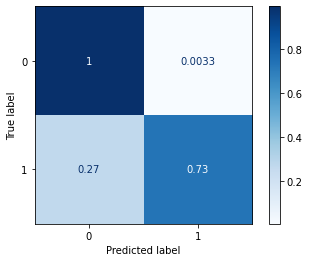

In [37]:
cm = confusion_matrix(y_test, tpot_pred, normalize = 'true')

cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

Save best TPOT model

In [38]:
TPOT_exported_pipeline = pipeline_optimizer.fitted_pipeline_

In [39]:
tpot_results = TPOT_exported_pipeline.predict(X_test)

Double check:

In [40]:
precision_recall_fscore_support(y_test, tpot_results, beta = 0.5)

(array([0.96141479, 0.97058824]),
 array([0.99666667, 0.73333333]),
 array([0.96826425, 0.91160221]),
 array([300,  45], dtype=int64))

In [41]:
pkl_filename = '../models/restricted_tpot_best_fitted.pkl'
pickle.dump(TPOT_exported_pipeline, open(pkl_filename, 'wb'))

# 7 Model selection

Let's compare the best models:

|           | ADAboost        |         | TPOT            |         |
|-----------|-----------------|---------|-----------------|---------|
| accuracy  | 96.23%           |         | 96.23%           |         |
|           | _Did not achieve_ | _Achieved_ | _Did not Achieve_ | _Achieved_ |
| precision | 97%             | 90%     | 96%             | 97%     |
| recall    | 98.7%             | 80%     | 99.6%             | 73%     |
| f-score   | 97.3%             | 87.8%     | 96.8%           | 91.2%   |

TPOT has better _precision_ when it comes to the farmers who _achieved_ the living income benchmark (i.e., from the 34 predictions from the TPOT model, 33 where correct; the ADAboost made 40 predictions, 36 correct).

On the other hand, ADAboost has better _recall_ (i.e., from the 45 farmers that _achieved_ the living income benchmark, 36 were found by the ADAboost, while only 33 where found by the TPOT model)

Because the ADAboost is more balanced in precision and recall, I prefer this model over the TPOT best pipeline

In [28]:
best_model =  best_clf_strat

In [29]:
pkl_filename = '../models/restricted_best_overall.pkl'
pickle.dump(best_model, open(pkl_filename, 'wb'))

# 8 Probabilities

Besides predicting if a farmer reaches a living income, I'm interested in predicting the probability that a farmer reaches a living income. I do this by calibrating the original model `proba`

For reference see [probability calibration](https://scikit-learn.org/stable/modules/calibration.html#calibration) and this cross-validated [post](https://stats.stackexchange.com/questions/110981/why-is-adaboost-predicting-probabilities-with-so-little-standard-deviation)

## 8.1 AdaBoostClassifier 

This is the average chance that an observation is classified as reaching a living income (`true`)

In [30]:
np.mean(best_clf_strat.predict(X_test))

0.11594202898550725

However, this is the average probability that an observation reaches the living income (`proba`) before calibration

In [31]:
np.mean(best_clf_strat.predict_proba(X_test)[:,1])

0.47577319151783504

Which are clearly not in line.

To adjust this, we calibrate the classifier

In [32]:
calibrated_best_clf_strat = CalibratedClassifierCV(best_clf_strat, cv=cv_strat, method='isotonic')

In [33]:
calibrated_best_clf_strat.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=AdaBoostClassifier(learning_rate=0.1,
                                                         n_estimators=1500,
                                                         random_state=42),
                       cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
                       method='isotonic')

Let's compare the predictions:

In [34]:
calibrated_best_predictions_strat = calibrated_best_clf_strat.predict(X_test)

In [35]:
confusion_matrix(y_test, calibrated_best_predictions_strat)

array([[295,   5],
       [  9,  36]], dtype=int64)

In [36]:
confusion_matrix(y_test, best_predictions_strat)

array([[296,   4],
       [  9,  36]], dtype=int64)

Predictions are virtually identical. Let's extract the probabilities now:

In [37]:
calibrated_best_probabilities_strat = calibrated_best_clf_strat.predict_proba(X_test)[:,1]

Let's now see the average calibrated chance that an observation is classified as reaching a living income (`true`)

In [38]:
np.mean(calibrated_best_probabilities_strat)

0.1241827393848341

Which now is in line with:

In [39]:
np.mean(calibrated_best_predictions_strat)

0.11884057971014493

## 8.2 TPOT

For completness, we do similar to the TPOT best model

In [54]:
calibrated_tpot = CalibratedClassifierCV(TPOT_exported_pipeline, cv=cv_strat, method='isotonic')

In [55]:
calibrated_tpot.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('stackingestimator',
                                                       StackingEstimator(estimator=BernoulliNB(alpha=100.0,
                                                                                               fit_prior=False))),
                                                      ('rfe',
                                                       RFE(estimator=ExtraTreesClassifier(criterion='entropy',
                                                                                          max_features=0.8,
                                                                                          random_state=32),
                                                           step=0.9000000000000001)),
                                                      ('normalizer',
                                                       Normalizer(norm='l1')),
                                                      ('gradientboostingclassi

In [56]:
calibrated_tpot_predictions = calibrated_tpot.predict(X_test)

In [57]:
confusion_matrix(y_test, calibrated_tpot_predictions)

array([[298,   2],
       [ 10,  35]], dtype=int64)

In [58]:
confusion_matrix(y_test, tpot_pred)

array([[299,   1],
       [ 12,  33]], dtype=int64)

In [59]:
calibrated_tpot_probabilities = calibrated_tpot.predict_proba(X_test)[:,1]

In [60]:
np.mean(calibrated_tpot_probabilities)

0.12618606828750847

In [61]:
np.mean(calibrated_tpot_predictions)

0.1072463768115942

## 8.3 Export best calibrated model

In [40]:
best_calibrated_model =  calibrated_best_clf_strat

In [42]:
pkl_filename = '../models/LI_simplified_model.pkl'
pickle.dump(best_calibrated_model, open(pkl_filename, 'wb'))

# 9 Web app & write-ups

## 9.0 Previous non-technical write-up:

See at [medium](https://medium.com/@tyszler.jobs/are-cocoa-farmers-reaching-a-living-income-f7724af574c4?sk=344c18d46a7fd402d3a137061c6ba89a)


## 9.1 Non-technical write-up

See See at [medium](https://medium.com/@tyszler.jobs/are-cocoa-farmers-reaching-a-living-income-f7724af574c4?sk=344c18d46a7fd402d3a137061c6ba89a)

## 9.2 Technical write-up

See at [medium](https://medium.com/@tyszler.jobs/are-cocoa-farmers-reaching-a-living-income-f7724af574c4?sk=344c18d46a7fd402d3a137061c6ba89a)

## 9.3 Web app

See it [live](https://disaster-response-livedemo.herokuapp.com/)
